In [51]:
from qiskit import QuantumCircuit
# from qiskit_utils import algorithm_globals
from qiskit_algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import *
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import *
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [52]:
#Dims
rows = 3
cols = 3

#construct a matrix representation of vertices/tiles, matrix[row][col]
tile_matrix = np.zeros(shape=(rows,cols), dtype=int)
tile_mappings = dict()
tile_count = 0
for r in range(rows):
    for c in range(cols):
        tile_matrix[r,c] = tile_count
        tile_mappings[tile_count] = (r,c)
        tile_count += 1

print(tile_matrix)

def make_edge(u,v):
    return "e(%d,%d)" % (min(u,v), max(u,v))

#primitive: tuple (number, dir) i.e. 0d is for the downward edge on 0
#full edge: e(u,v) where u < v
#half edge: h(u,dir)
edge_mappings = dict()
#establish edges by trying to go up down left right in the matrix.
for r in range(rows):
    for c in range(cols):
        this_tile = tile_matrix[r,c] #id of tile at row r and column c
        #down edge (r+1)
        if (rows==1): #cannot use edges, t is for tile, and vertical and horizontal tiles can be present in the same location (to form cross)
            edge_mappings["t(%d,%s)" % (tile_matrix[r,c],'v')] = [(tile_matrix[r,c], 'd'),(tile_matrix[r,c], 'u')]
        elif (r+1 < rows):
            e_down = make_edge(this_tile, tile_matrix[r+1,c])
            edge_mappings[e_down] = [(this_tile, 'd'), (tile_matrix[r+1,c], 'u')]
            if (r == 0):
                edge_mappings[e_down].append((this_tile,'u'))
            if (r+1 == rows-1):
                edge_mappings[e_down].append((tile_matrix[r+1,c],'d'))

        #right edge (c+1)
        if (cols==1):
            edge_mappings["t(%d,%s)" % (tile_matrix[r,c],'h')] = [(tile_matrix[r,c], 'r'),(tile_matrix[r,c], 'l')]
        elif (c+1 < cols): 
            e_right = make_edge(this_tile, tile_matrix[r,c+1])
            edge_mappings[e_right] = [(this_tile, 'r'), (tile_matrix[r,c+1], 'l')]
            if (c == 0):
                edge_mappings[e_right].append((this_tile,'l'))
            if (c+1 == cols-1):
                edge_mappings[e_right].append((tile_matrix[r,c+1],'r'))
print(edge_mappings)

#mapping primitive i.e. (0,'d') to an edge i.e. (0,2)
h_mappings = dict()

for key in edge_mappings:
    for prim in edge_mappings[key]:
        h_mappings[prim] = key

# Create a QUBO
qubo = QuadraticProgram()

#linear combination coefficient:
coefs = {}
for edge in edge_mappings:
    qubo.binary_var(edge)
    if edge[0] == "t":
        coefs[edge] = 0
    else:
        coefs[edge] = None

# qubo.linear_constraint(linear={"up":2,"left":1,"down":-2,"right":-1}, sense="==", rhs=0)

for r in range(rows):
    for c in range(cols):
        this_tile = tile_matrix[r,c]
        edge_u = h_mappings[(this_tile, 'u')]
        edge_d = h_mappings[(this_tile, 'd')]
        edge_l = h_mappings[(this_tile, 'l')]
        edge_r = h_mappings[(this_tile, 'r')]
        if edge_u != edge_d:
            qubo.linear_constraint(linear={edge_u:1, edge_d:-1}, sense="==", rhs=0)
            coefs[edge_u] = 1
            coefs[edge_d] = 1
        elif coefs[edge_u] == None:
            coefs[edge_u] = 0
        if edge_r != edge_l:
            qubo.linear_constraint(linear={edge_r:1, edge_l:-1}, sense="==", rhs=0)
            coefs[edge_r] = 1
            coefs[edge_l] = 1
        elif coefs[edge_r] == None:
            coefs[edge_r] = 0

        

qubo.minimize(linear = coefs, quadratic={})


print(qubo.prettyprint())

[[0 1 2]
 [3 4 5]
 [6 7 8]]
{'e(0,3)': [(0, 'd'), (3, 'u'), (0, 'u')], 'e(0,1)': [(0, 'r'), (1, 'l'), (0, 'l')], 'e(1,4)': [(1, 'd'), (4, 'u'), (1, 'u')], 'e(1,2)': [(1, 'r'), (2, 'l'), (2, 'r')], 'e(2,5)': [(2, 'd'), (5, 'u'), (2, 'u')], 'e(3,6)': [(3, 'd'), (6, 'u'), (6, 'd')], 'e(3,4)': [(3, 'r'), (4, 'l'), (3, 'l')], 'e(4,7)': [(4, 'd'), (7, 'u'), (7, 'd')], 'e(4,5)': [(4, 'r'), (5, 'l'), (5, 'r')], 'e(5,8)': [(5, 'd'), (8, 'u'), (8, 'd')], 'e(6,7)': [(6, 'r'), (7, 'l'), (6, 'l')], 'e(7,8)': [(7, 'r'), (8, 'l'), (8, 'r')]}
Problem name: 

Minimize
  e(0,1) + e(0,3) + e(1,2) + e(1,4) + e(2,5) + e(3,4) + e(3,6) + e(4,5) + e(4,7)
  + e(5,8) + e(6,7) + e(7,8)

Subject to
  Linear constraints (6)
    -e(0,1) + e(1,2) == 0  'c0'
    e(0,3) - e(3,6) == 0  'c1'
    e(1,4) - e(4,7) == 0  'c2'
    -e(3,4) + e(4,5) == 0  'c3'
    e(2,5) - e(5,8) == 0  'c4'
    -e(6,7) + e(7,8) == 0  'c5'

  Binary variables (12)
    e(0,3) e(0,1) e(1,4) e(1,2) e(2,5) e(3,6) e(3,4) e(4,7) e(4,5) e(5,8) e(6,7)


In [53]:
converter = QuadraticProgramToQubo()
qubo_with_penalty = converter.convert(qubo)
op, offset = qubo_with_penalty.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 45.0
operator:
SparsePauliOp(['IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIZII', 'IIIIIIIIZIII', 'IIIIIIIZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZIIIIIII', 'IIIZIIIIIIII', 'IIZIIIIIIIII', 'IZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIZIZI', 'IIIIIIZIIIIZ', 'IIIIZIIIIZII', 'IIIZIZIIIIII', 'IIZIIIIZIIII', 'ZZIIIIIIIIII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -6.5+0.j, -6.5+0.j,
 -6.5+0.j, -6.5+0.j, -6.5+0.j, -6.5+0.j])


In [54]:
qaoa_mes = QAOA(sampler=Sampler(options={"shots":1000000}), optimizer=COBYLA())
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: 0.0
variable values: e(0,3)=0.0, e(0,1)=0.0, e(1,4)=0.0, e(1,2)=0.0, e(2,5)=0.0, e(3,6)=0.0, e(3,4)=0.0, e(4,7)=0.0, e(4,5)=0.0, e(5,8)=0.0, e(6,7)=0.0, e(7,8)=0.0
status: SUCCESS


In [55]:
print("variable order:", [var.name for var in qaoa_result.variables])

print(len(qaoa_result.samples))

for s in qaoa_result.samples:
    if (s.status==OptimizationResultStatus.SUCCESS):
        print(s)

variable order: ['e(0,3)', 'e(0,1)', 'e(1,4)', 'e(1,2)', 'e(2,5)', 'e(3,6)', 'e(3,4)', 'e(4,7)', 'e(4,5)', 'e(5,8)', 'e(6,7)', 'e(7,8)']
450
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=0.0, probability=0.016564, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=2.0, probability=0.016164, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), fval=2.0, probability=0.016009, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), fval=2.0, probability=0.016429, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), fval=2.0, probability=0.016319, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), fval=2.0, probability=0.0

In [56]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.001, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

print(s)

SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=0.0, probability=0.016564, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=2.0, probability=0.016164, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), fval=2.0, probability=0.016009, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), fval=2.0, probability=0.016429, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), fval=2.0, probability=0.016319, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), fval=2.0, probability=0.016263, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]), fval=2.0, prob

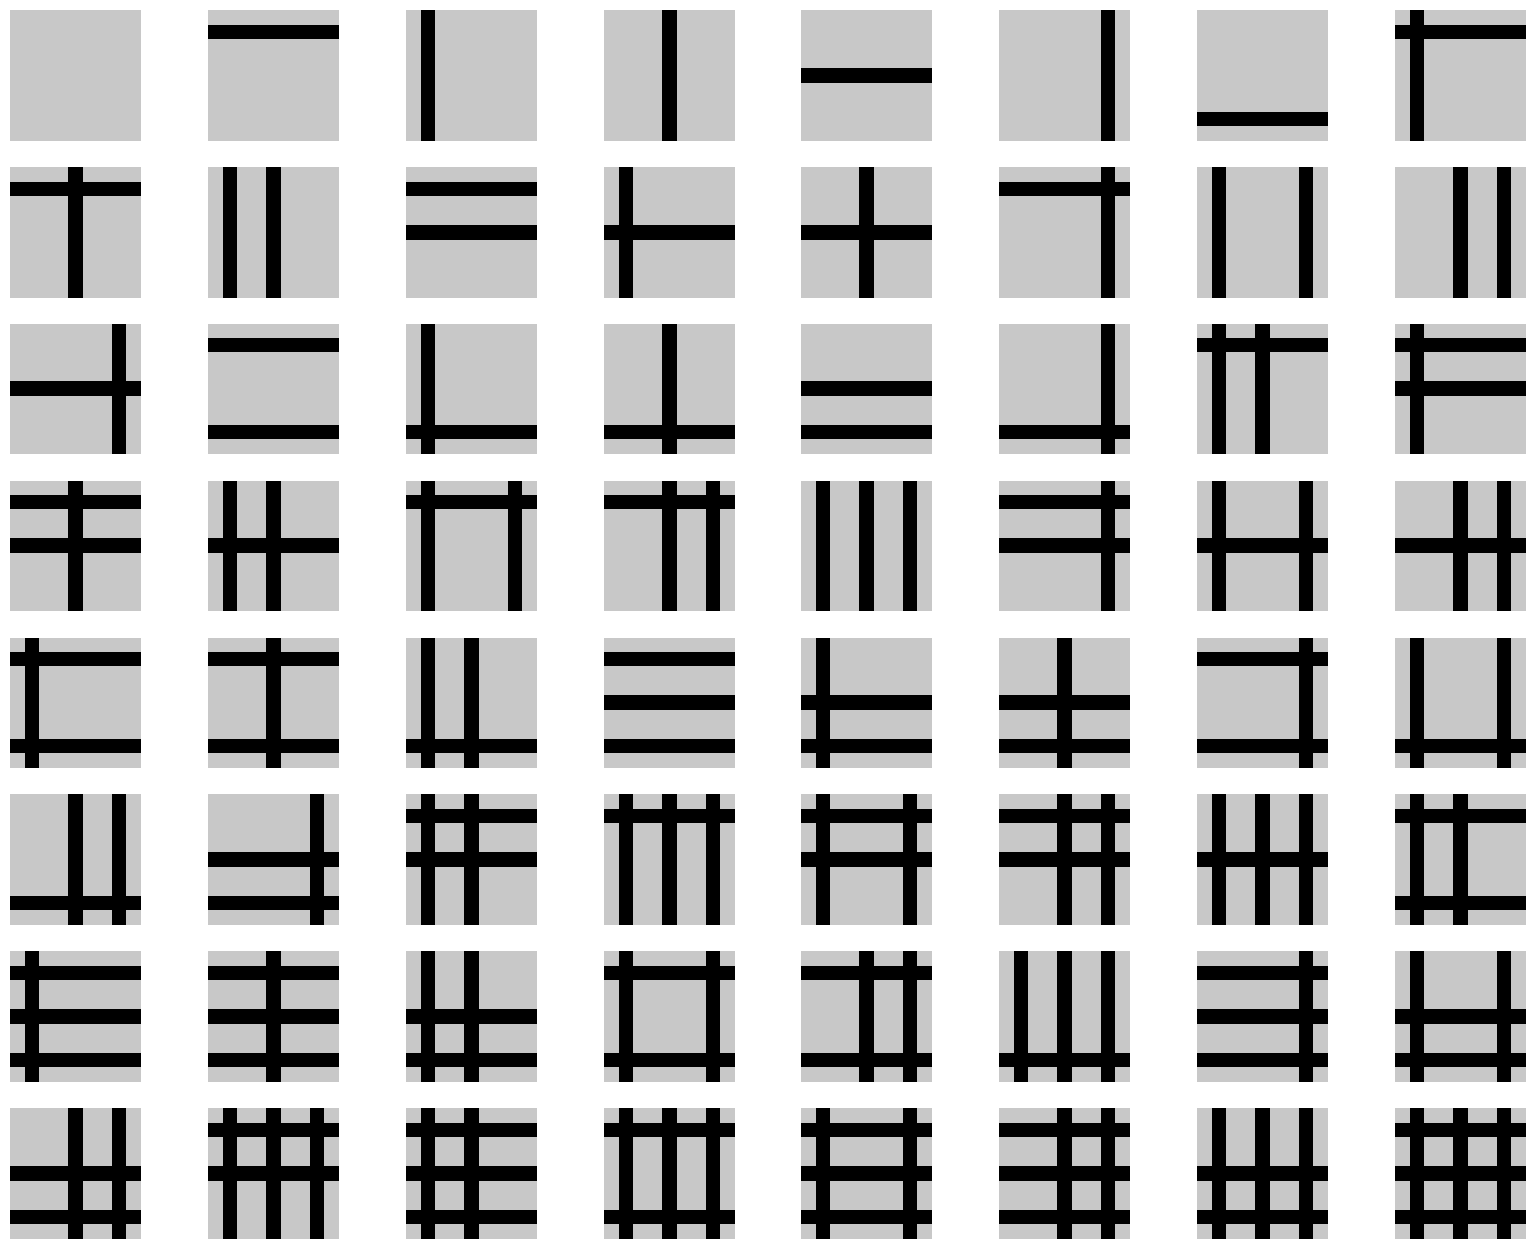

In [57]:
height, width, channel = 3 * rows, 3 * cols, 3

figcols = 25 // cols
figrows = len(filtered_samples) // figcols + 1
fig = plt.figure(figsize=(20, figrows * 2)) 


def paint(tile_mappings, h):
    tile, dir = h
    r, c = tile_mappings[tile]
    center = (r * 3 + 1, c * 3 + 1) #center of the (r,c) tile on the canvas
    dir_modifier = None
    if dir == 'u':
        dir_modifier = (-1,0)
    if dir == 'd':
        dir_modifier = (1,0)
    if dir == 'l':
        dir_modifier = (0,-1)
    if dir == 'r':
        dir_modifier = (0,1)
    draw_tile_dir = (center[0] + dir_modifier[0], center[1] + dir_modifier[1])
    return [center, draw_tile_dir]

for s in range(len(filtered_samples)):
    arr = np.full((height, width, channel), [200, 200, 200], dtype=('uint8'))
    draw_target = filtered_samples[s]
    for i, v in enumerate(draw_target.x):
        if int(v) == 1:
            e = qaoa_result.variables[i].name
            prims = edge_mappings[e]
            for p in prims:
                paint_tiles = paint(tile_mappings, p)
                for t in paint_tiles:
                    for chan in range(3):
                        arr[t[0], t[1], chan] = 0
    fig.add_subplot(figrows, figcols, s + 1)
    plt.imshow(arr)
    plt.axis('off')

Sample with probability 0.016564
Variables with value 1:
Sample with probability 0.016164
Variables with value 1:
e(0,1)
e(1,2)
Sample with probability 0.016009
Variables with value 1:
e(0,3)
e(3,6)
Sample with probability 0.016429
Variables with value 1:
e(1,4)
e(4,7)
Sample with probability 0.016319
Variables with value 1:
e(3,4)
e(4,5)
Sample with probability 0.016263
Variables with value 1:
e(2,5)
e(5,8)
Sample with probability 0.016235
Variables with value 1:
e(6,7)
e(7,8)
Sample with probability 0.015976
Variables with value 1:
e(0,3)
e(0,1)
e(1,2)
e(3,6)
Sample with probability 0.015979
Variables with value 1:
e(0,1)
e(1,4)
e(1,2)
e(4,7)
Sample with probability 0.015915
Variables with value 1:
e(0,3)
e(1,4)
e(3,6)
e(4,7)
Sample with probability 0.015994
Variables with value 1:
e(0,1)
e(1,2)
e(3,4)
e(4,5)
Sample with probability 0.01585
Variables with value 1:
e(0,3)
e(3,6)
e(3,4)
e(4,5)
Sample with probability 0.015784
Variables with value 1:
e(1,4)
e(3,4)
e(4,7)
e(4,5)
Sample w

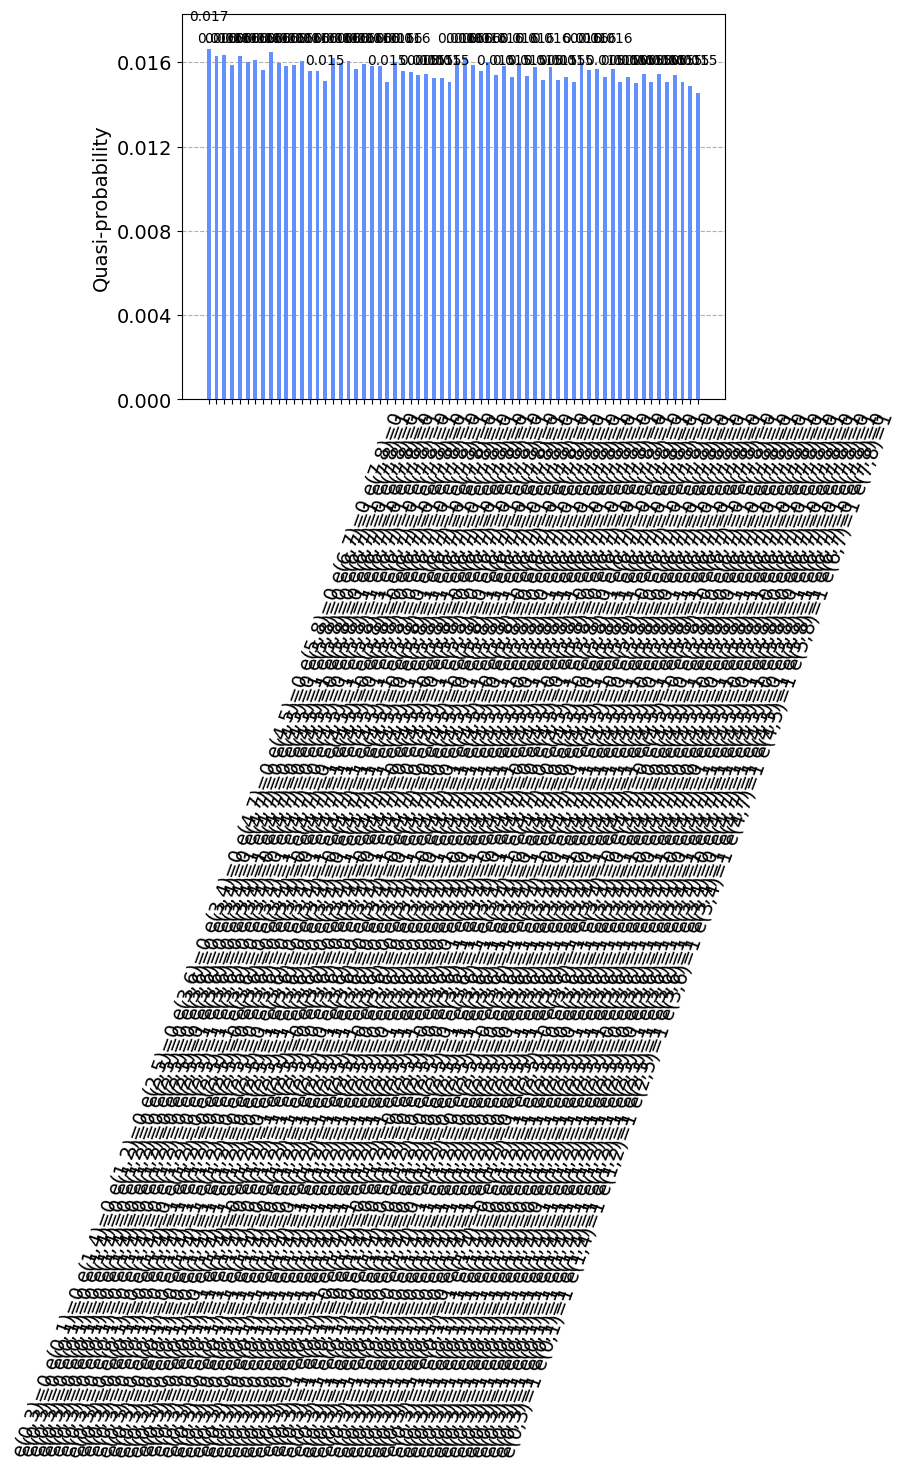

In [58]:
samples_for_plot = {}

for s in filtered_samples:
    sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

    samples_for_plot[sample_str] = s.probability

    print("Sample with probability", s.probability)
    print("Variables with value 1:")
    for i, v in enumerate(s.x):
        if int(v) == 1:
            print(qaoa_result.variables[i].name)

plot_histogram(samples_for_plot)
